In [30]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

from qiskit.circuit.library import QFT, CPhaseGate

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [129]:
depolarizing_prob = 0.1
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

In [132]:
def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def mean(x: list, y: list):                 #bildet den Mittelwert unter den Shots einer Messung
    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m

def QPE(angle: float, precision: int) -> QuantumCircuit:
    qr = QuantumRegister(precision+1,"q")
    cbit = ClassicalRegister(precision,"c")
    qc = QuantumCircuit(qr,cbit)
    
    qc.x(precision)

    for i in range(precision):
        qc.h(i)
        for j in range(2**(i)):
            qc.cp(theta=2*np.pi*angle, control_qubit=i, target_qubit=precision)

    qft = QFT(num_qubits=precision, inverse=True).to_gate()
    hmm = [i for i in range(precision)]         #Liste der Qubits auf denen iQFT andgewendet wird
    qc.append(qft,qargs=hmm)
    return qc

In [163]:
def prec_over_error(angle: float, n: int, shots: int, steps:int ,times: int):
    error_1 = np.linspace(0,4/3,steps)
    error_2 = np.linspace(0,16/15,steps)
    x = np.linspace(0,1,steps)
    y_idk = np.zeros(len(x))
    for o in range(times):
        for j in range(len(error_1)):
            dep_error = depolarizing_error(error_1[j], 1)
            dep_error_2q = depolarizing_error(error_2[j], 2)

            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
            noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

            qc = QPE(angle=angle, precision=n)

            for i in range(n):
                qc.measure(i,i)

            sim = AerSimulator()
            job = sim.run(qc.decompose(reps=n), noise_model=noise_model, shots=shots)
            result = job.result()
            counts = result.get_counts()    
                
            # x_old = list(counts.keys())
            # x_old = [convert(i) for i in x_old]
            # y_old = list(counts.values())
            # avg = mean(x_old,y_old)
            # y_idk[j] += np.abs(avg-angle)

            most = convert(max(counts, key=counts.get))
            y_idk[j] += np.abs(most-angle)

    y = [i/times for i in y_idk]
    fig, ax = plt.subplots(figsize=(13,7))
    ax = plt.plot(x,y, "x", label="Precision", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average
    plt.title("QPE: Dependence of Precision on the depolarizing errror with "+r"$\Theta$"+" = {}, {} ancillas and {} shots".format(angle, n, int(shots)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \text{max}(\varphi) - \Theta \vert$")
    plt.xlabel("Depolarizing error")
    data = np.array((x,y))
    np.savetxt("QPE_error_threshhold.txt", data, delimiter=",")
    return plt.legend()
        

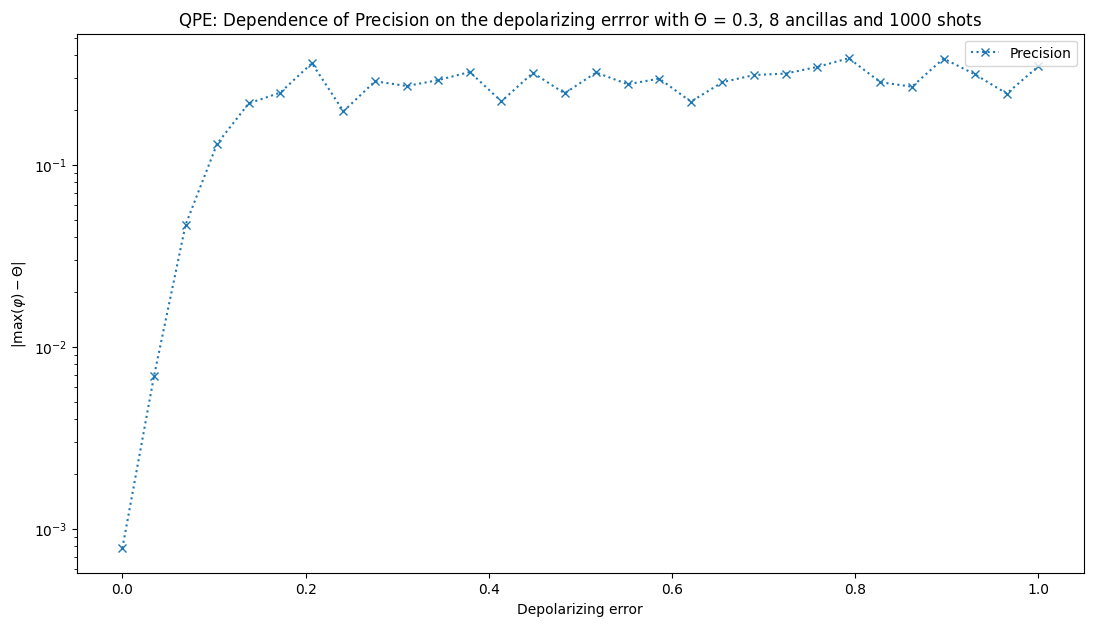

In [164]:
prec_over_error(0.3, 8, 1000, 30, 10)